In [ ]:
#!pip install nibabel
%matplotlib notebook
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#plt.rcParams.update(params)
import h5py
import random
from tqdm.notebook import tqdm
import nibabel as nib
import time
import matplotlib.animation as animation
#plt.rcParams["animation.html"] = "jshtml"
from glob import glob
from scipy.stats import ks_2samp
from IPython.display import HTML

In [ ]:
BASEPATH = "C:\\Users\\nemet\\OneDrive\\Desktop\\TReNDS Git\\"

# Exploration of main directory

In [ ]:
fnc = pd.read_csv(BASEPATH+"fnc.csv")
sample_submission = pd.read_csv(BASEPATH+"sample_submission.csv")
loading = pd.read_csv(BASEPATH+"loading.csv")
ICN_numbers = pd.read_csv(BASEPATH+"ICN_numbers.csv")
train_scores = pd.read_csv(BASEPATH+"train_scores.csv")
reveal_ID_site2 = pd.read_csv(BASEPATH+"reveal_ID_site2.csv")

In [ ]:
print(sample_submission.head())
print(train_scores.head())
print(fnc.head())

# Visualization of .mat files

   Read in .mat files, __n_layers__ : No. of "slices"
   
   __HTML__ : only in Jupyter for animation
    

In [ ]:
#Only for Jupyter animations:
#!pip install ffmpeg

#http://blog.gregzaal.com/how-to-install-ffmpeg-on-windows/

FFMPEG_PATH = r"C:\\ffmpeg\\"

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = FFMPEG_PATH

f = h5py.File(f'{BASEPATH}fMRI_test\\10003.mat','r')
data = f['SM_feature']
array = data[()]

def retrieve_im(i):
    return array[i, :, 10, :]

n_layers = array.shape[-1]

fig, ax = plt.subplots()
"""
def updatefig(*args):
    global i
    print(i)
    if i < 50:
        im.set_array(retrieve_im(i))

    else:
        im.set_array(retrieve_im(50))
        
    return im,
"""


ims = []
for i in range(n_layers):
    
    im = plt.imshow(retrieve_im(i), animated=True)
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims
                              , interval=50, blit=True,
                                repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())


# 3D visualization with matplotlib voxels

convert h5py array to 3d numpy array

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook
%matplotlib inline

def retrieve_im(i):
    return list(array[1, :, i, :])


im = []
for k in range(0,50):
    layer = []
    for i in range(0,len(array[1, :, k, :])):
                   
        layer.append(list(array[1, :, k, :][i]))
    im.append(binarize(layer))


from sklearn.preprocessing import binarize

N=55
volume = np.array(im)

filled = np.array(im, dtype=np.bool)

# repeating values 3 times for grayscale
colors = np.array(np.absolute(volume[:, :, :, np.newaxis]))

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.voxels(filled, edgecolors='k')
plt.show()

# Nilearn visualization (.nii files)

https://www.kaggle.com/eswarchandt/nilearn-visualizations-and-nn-baseline

In [ ]:
#!pip install nilearn
from nilearn import plotting
plotting.plot_glass_brain(f"{BASEPATH}TReNDS Git\\fMRI_mask.nii") 

In [19]:
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib
import h5py
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
mask_filename = f"{BASEPATH}fMRI_mask.nii"
subject_filename = f"{BASEPATH}fMRI_test\\10003.mat"
smri_filename = f"{BASEPATH}ch2better.nii"
mask_niimg = nl.image.load_img(mask_filename)

def load_subject(filename, mask_niimg):
    """
    Load a subject saved in .mat format with
        the version 7.3 flag. Return the subject
        niimg, using a mask niimg as a template
        for nifti headers.
        
    Args:
        filename    <str>            the .mat filename for the subject data
        mask_niimg  niimg object     the mask niimg object used for nifti headers
    """
    subject_data = None
    with h5py.File(subject_filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    return subject_niimg

subject_niimg = load_subject(subject_filename, mask_niimg)


print("Image shape is %s" % (str(subject_niimg.shape)))
num_components = subject_niimg.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))

Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


C:\Users\nemet\anaconda3\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)
C:\Users\nemet\anaconda3\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


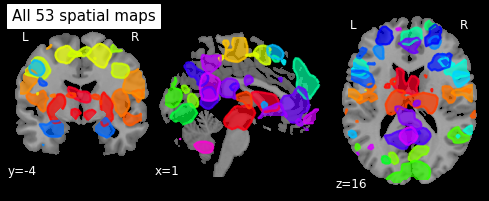

In [20]:
nlplt.plot_prob_atlas(subject_niimg, bg_img=smri_filename, 
                      view_type='filled_contours', draw_cross=False, 
                      title='All %d spatial maps' % num_components, 
                      threshold='auto')

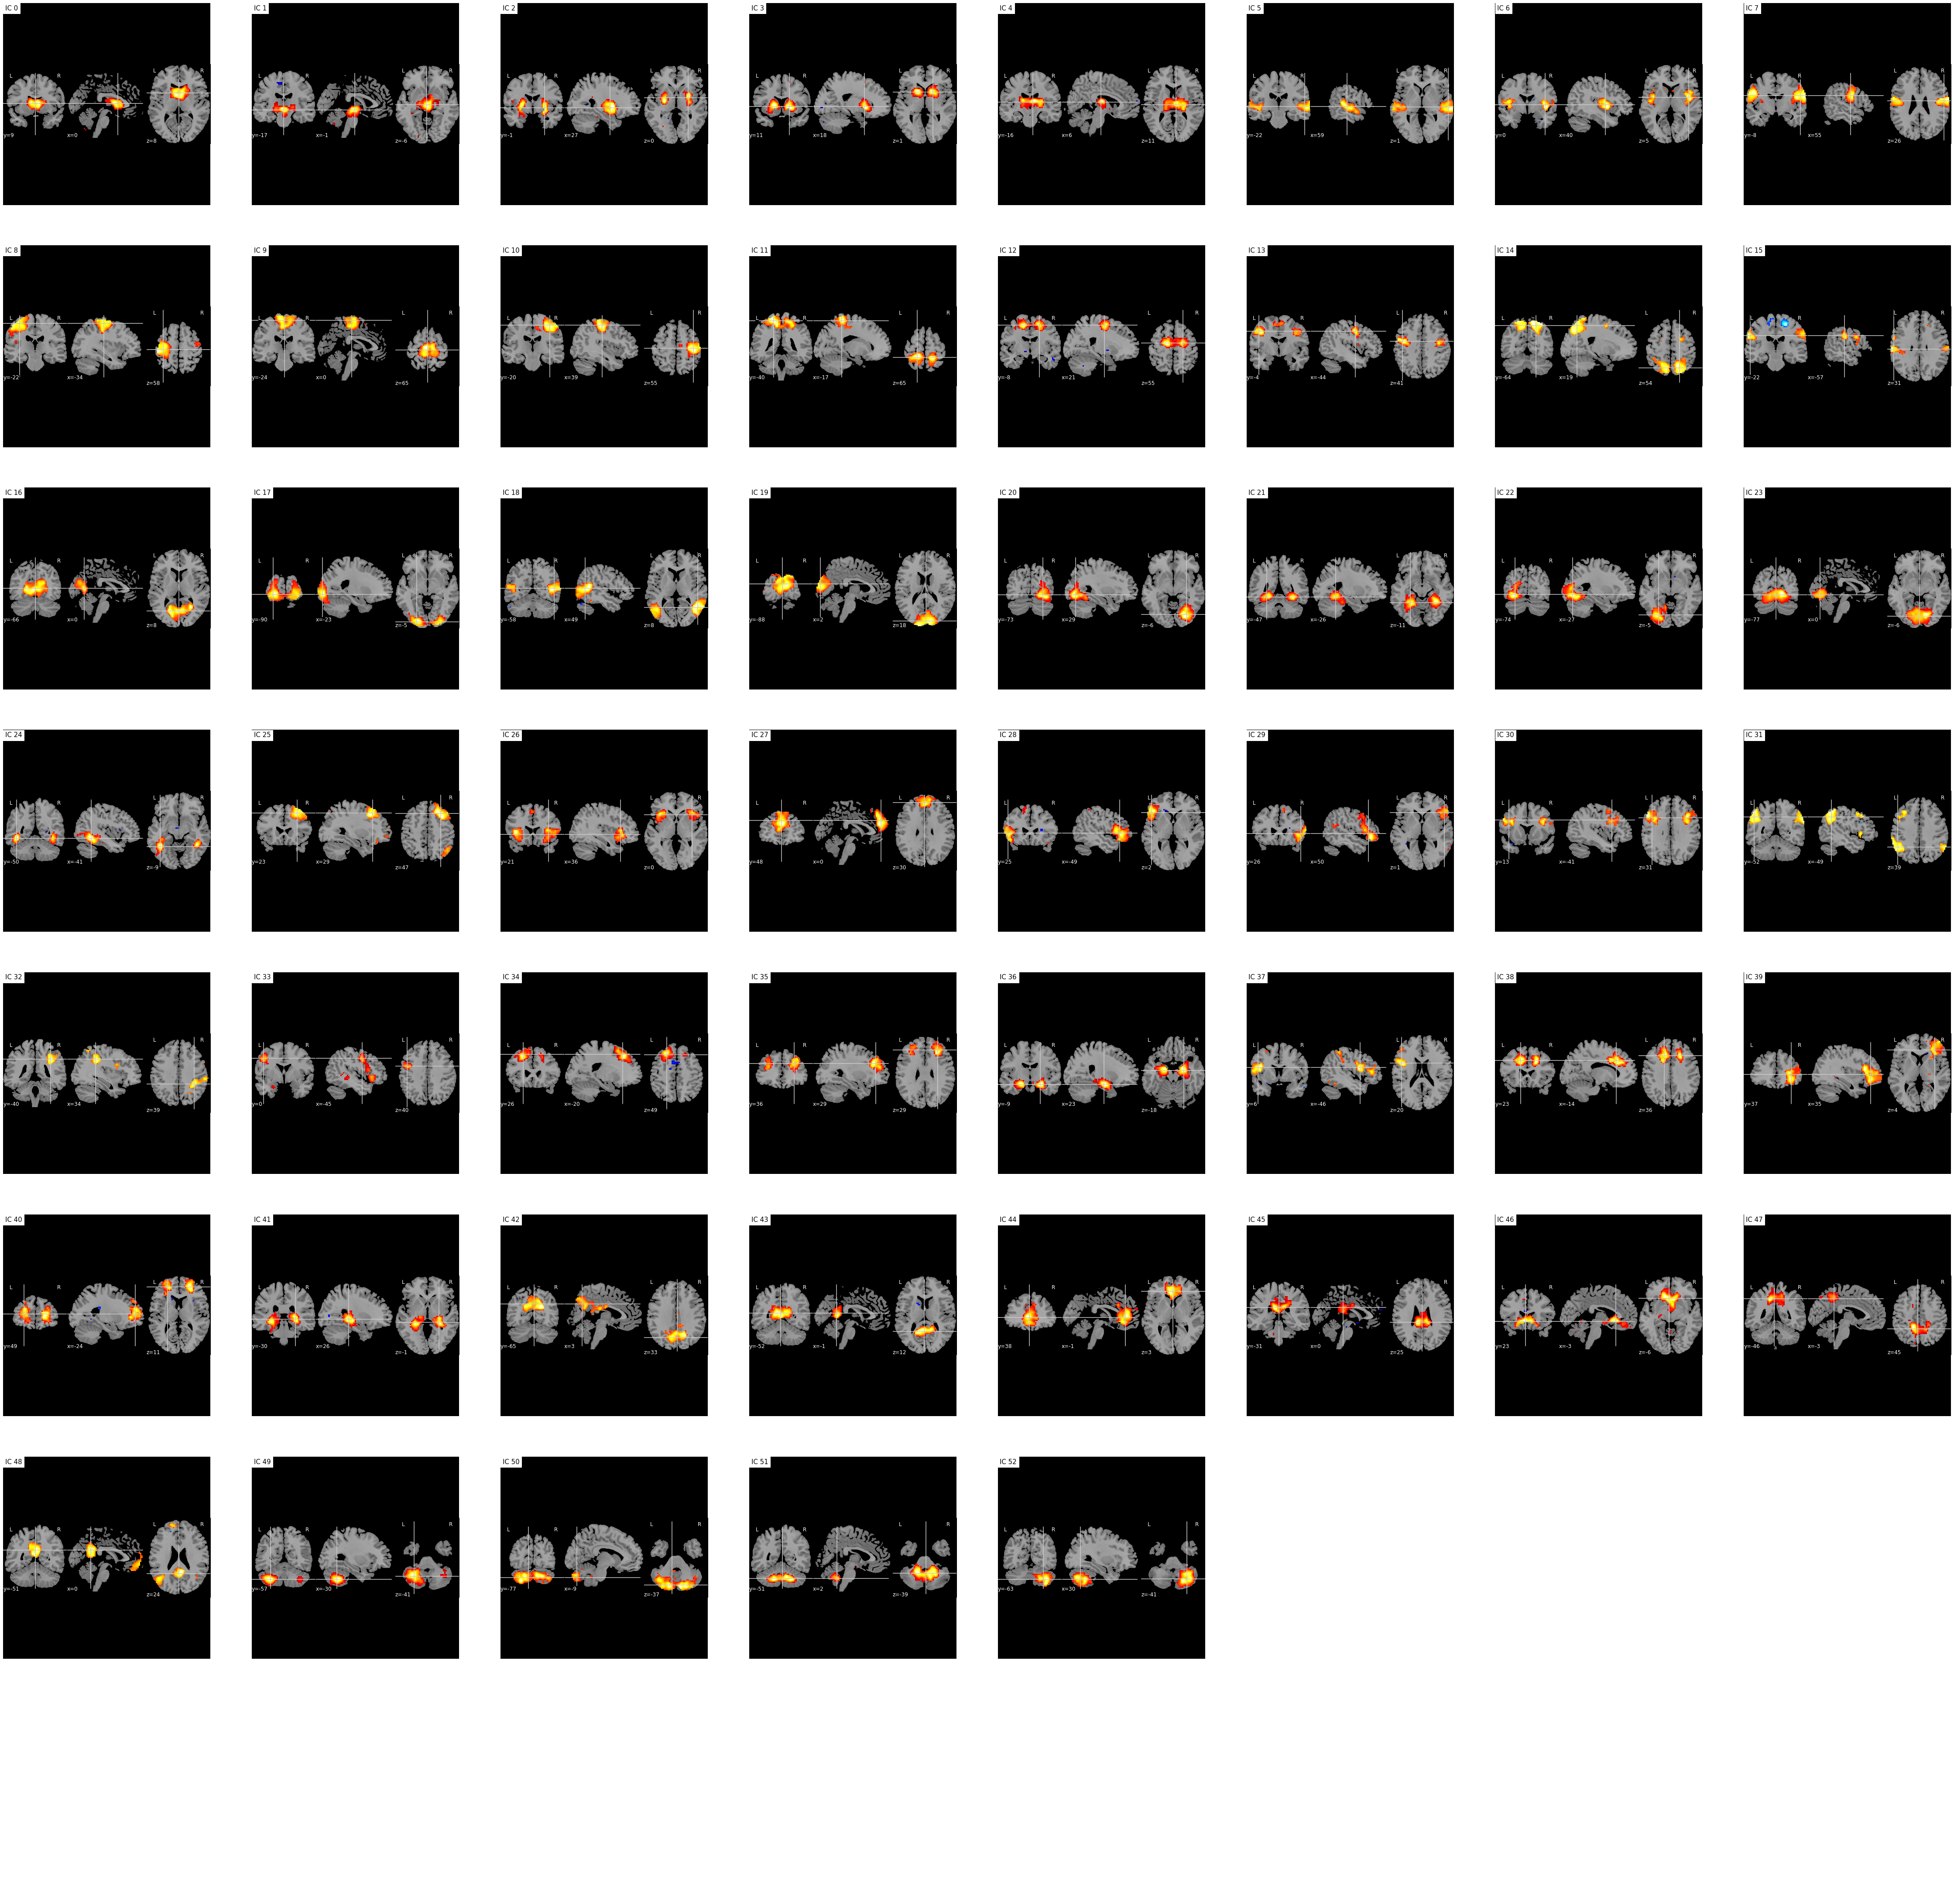

In [21]:
grid_size = int(np.ceil(np.sqrt(num_components)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1
for i, cur_img in enumerate(nl.image.iter_img(subject_niimg)):
    col = i % grid_size
    if col == 0:
        row += 1
    nlplt.plot_stat_map(cur_img, bg_img=smri_filename, title="IC %d" % i, axes=axes[row, col], threshold=3, colorbar=False)